# Iceberg detection

The ocean- and iceberg-filtering tools in pDEMtools were built upon the methods of [Shiggins _et al._ (2023)](https://doi.org/10.5194/tc-17-15-2023), which was originally intended to identify icebergs. Hence, we can use the pDEMtool functions to also extract iceberg geometry!

In [1]:
import os

import pdemtools as pdt

As well as `pdemtools`, we will also make use of `matplotlib` to plot our results in this notebook.

In [2]:
import matplotlib.pyplot as plt

plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['font.sans-serif'] = "Arial"

# %matplotlib widget

## Finding a strip

Let's have a look at the icebergs in Kangerdlugssuaq fjord:

In [3]:

index_fpath = '.../ArcticDEM_Strip_Index_s2s041_gpqt.parquet'

bounds = (490000,-2302000,510000,-2290000)

gdf = pdt.search(
    index_fpath, 
    bounds, 
    dates = '20160101/20221231',
    months = [6,7,8,9],
    baseline_max_hours = 24,
    sensors=['WV03', 'WV02', 'WV01'],
    min_aoi_frac = 0.7,
)

gdf = gdf.sort_values('acqdate1')

print(f'{len(gdf)} strips found')



6 strips found


Text(0.5, 1.0, '2017-07-08')

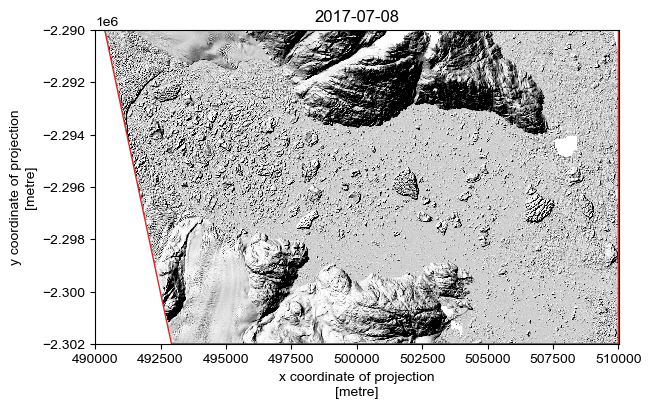

In [4]:

# =================
# SCENE TO PREVIEW
i = 2
# =================

preview = pdt.load.preview(gdf.iloc[[i]], bounds)

plt.close()
fig, ax = plt.subplots(layout='constrained')
preview.plot(cmap='Greys_r', add_colorbar=False)

gdf.iloc[[i]].plot(ax=ax, fc='none', ec='tab:red')

ax.set_title(gdf.iloc[[i]].acqdate1.dt.date.values[0])


In [5]:
i = 2

In [6]:

date = gdf.iloc[i].acqdate1
dem_id = gdf.iloc[i].dem_id


Downloading the 2 m strips, as always, may take quite a while. So let's download here but also make sure to save so that we can simple load next time we come back:

In [7]:
if not os.path.exists('example_data'):
    os.mkdir('example_data')

dem = pdt.load.from_search(gdf.iloc[i], bounds=bounds, bitmask=True)
dem.compute()  # rioxarray uses lazy evaluation, so we can force the download using the `.compute()` function.
dem.rio.to_raster(os.path.join('example_data', f'{dem_id}.tif'), compress='ZSTD', predictor=3, zlevel=1)


When returning to this notebook, we can now just load from the local filepath:

In [8]:
dem = pdt.load.from_fpath(os.path.join('example_data', f'{dem_id}.tif'), bounds=bounds)


Let's also calculate the hillshade, to overlay and aid visualisation:

In [9]:
hillshade = dem.pdt.terrain('hillshade', hillshade_multidirectional=True, hillshade_z_factor=2)

## Geoid correction

Our first move will be to geoid correct the dem.

By taking advantage of a local copy of the Greenland or Antarctica BedMachine, the `data` module's `geoid_from_bedmachine()` function can be used to quickly extract a valid geoid, reprojected and resampled to match the study area:

In [10]:
bedmachine_fpath = '.../BedMachineGreenland-v5.nc'

geoid = pdt.data.geoid_from_bedmachine(bedmachine_fpath, dem)

If you wish to use a different geoid (for instance, you are interested in a region outside of Greenland or Antarctica) you can also use your own geoid, loaded via xarray. To aid with this, a `geoid_from_raster()` function is also included in the `data` module, accepting a filepath to a `rioxarray.open_rasterio()`-compatible file type.

We can then correct the DEM using geoid and the `.pdt.geoid_correct()` function. 

In [11]:
dem = dem.pdt.geoid_correct(geoid)

## Sea level filtering

We can also filter out sea level from geoid-corrected DEMs, adapting the method of Shiggins _et al._ (2023) to detect sea level. 

In this workflow, sea-level is defined as the modal 0.25 m histogram bin between +10 and -10 metres above the geoid. If there is not at least 1 km<sup>2</sup> of surface between these values, then the DEM is considered to have no signficant ocean surface. Following Shiggins _et al._ (2023), we will set the DEM surface to be masked as ocean where the surface is within 1.5 m of the detected sea level. All of these values can be modified as input variables depending on your use case (you can examing how to interfact with the function via `help(dem.pdt.mask_ocean()` or consult the [readthedocs API reference](https://pdemtools.readthedocs.io/en/latest/api/pdt_accessor.html)).

Note that we will add the variable `return_sealevel_as_zero=True` to our `mask_ocean()` function. This subtracts the estimated sea level from the final DEM, meaning that the 0 m surface for the DEM is now the newly estimated sea level. This means that iceberg height values will now accurately reflect their height above the sea surface.

In [12]:
dem_masked = dem.pdt.mask_ocean(near_sealevel_thresh_m=1.5, return_sealevel_as_zero=True)

Text(0.5, 1.0, 'Kangerlussuaq Fjord (ocean-masked), 2017-07-08 22:47:46')

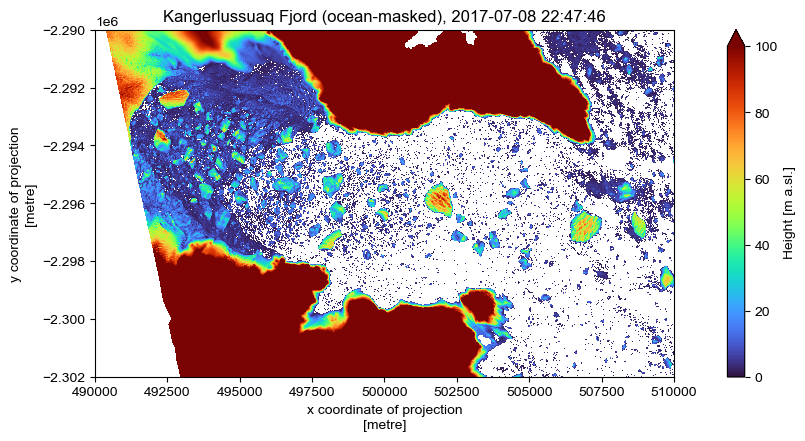

In [13]:
plt.close()
fig, ax = plt.subplots(figsize=(8,4.3))

dem_masked.plot(ax=ax, cmap='turbo', vmin=0, vmax=100, cbar_kwargs={'label': 'Height [m a.sl.]'})
# hillshade.plot(ax=ax, cmap='Greys_r', alpha=.3, add_colorbar=False)

ax.set_aspect('equal')
ax.set_title(f'Kangerlussuaq Fjord (ocean-masked), {date}')

This will filter out values close to the sea surface (within 1.5 m, according to the variable we have set above), but retain terrestrial land and ice. Note that the near-front region is not masked efficiently, as it is a contiguous proglacial mélange that mostly lies above the 1.5 m threshold. If we were interested in extracting only the larger icebergs and filtering out the mélange, we could increase the `near_sealevel_thresh_m` value. However, this would likewise filter out smaller icebergs in the open fjord. Shiggins _et al._ (2023) also get around this by manually clipping the analysis region to a central region of the fjord where no mélange enters throughout the time-series.

To extract only icebergs, we can filter out larger groups of pixels. pDEMtools offers this function as part of the `.pdt.mask_icebergs()` function, which wraps the `cv2.connectedComponentsWithStats` function to filter out contiguous areas beneath a provided area threshold (defaults to 1e<sup>6</sup> m<sup>2</sup>, i.e. 1 km<sup>2</sup>). By default, it masks out regions _beneath_ the threshold (i.e. keeping land/ice and removing icebergs) - we can alter this behaviour by setting the `retain_icebergs` flag to `True`.

In [14]:
dem_masked_bergs = dem_masked.pdt.mask_icebergs(area_thresh_m2=1e6, retain_icebergs=True)

This gives us a nice first pass at an iceberg map:

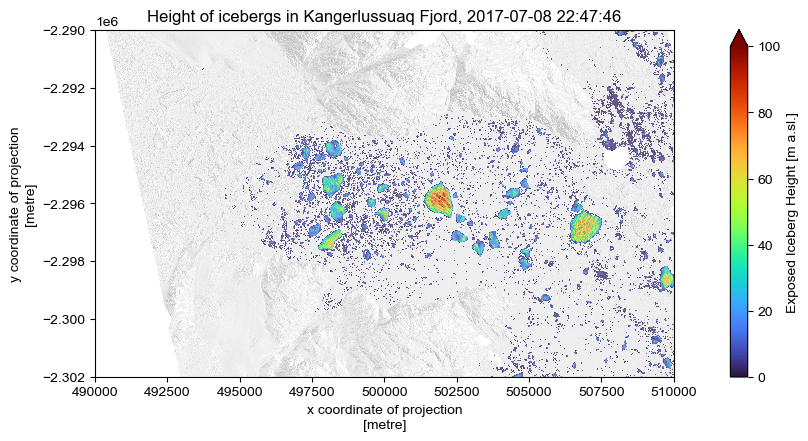

In [15]:
plt.close()
fig, ax = plt.subplots(figsize=(8,4.3))

dem_masked_bergs.plot(ax=ax, cmap='turbo', vmin=0, vmax=100, cbar_kwargs={'label': 'Exposed Iceberg Height [m a.sl.]'})
hillshade.plot(ax=ax, cmap='Greys_r', alpha=.3, add_colorbar=False)

ax.set_aspect('equal')
ax.set_title(f'Height of icebergs in Kangerlussuaq Fjord, {date}')

plt.savefig('../images/example_iceberg_height.jpg', dpi=300)

Note again that the immediate proglacial mélange is not picked up as icebergs. This is because it is one contiguous mass greater than 1 km<sup>2</sup>, so is filtered out by the `.pdt.mask_icebergs()` algorithm. 

Calculating simple iceberg distribution statistics can be easily done by making use of the `label` and `regionprops` function of scitkit-image:

In [16]:
import skimage.measure
import numpy as np

# Generate boolean mask in int8 format for cv2.connectedComponentsWithStats()
binary_mask = (~np.isnan(dem_masked_bergs.values)).astype(np.int8).squeeze()

# Generate labelled image
labeled_image, count = skimage.measure.label(binary_mask, return_num=True)

# Calculate statistics of labelled regions
objects = skimage.measure.regionprops(label_image=labeled_image, intensity_image=dem_masked_bergs.values)

# Extract desired iceberg statistic
resolution = 2
areas = [o['area'] * resolution**2 for o in objects]
volumes = [np.nansum(o['image_intensity'] * resolution**2) for o in objects]


Text(0.5, 1.0, 'Area vs Volume')

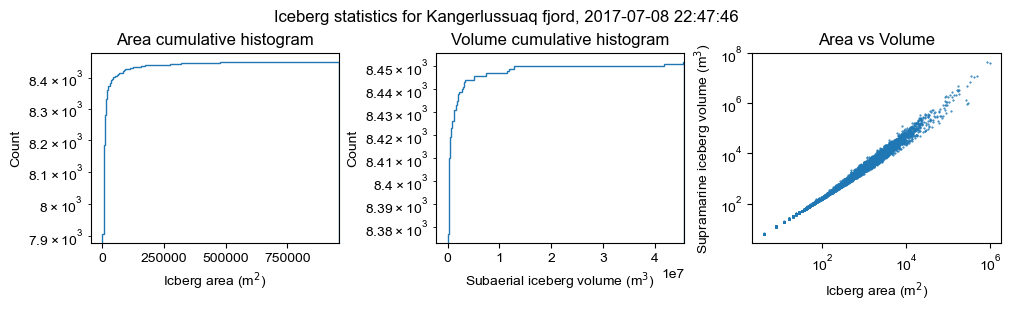

In [17]:
plt.close()
fig, axes = plt.subplots(ncols=3, figsize=(10,3))

fig.suptitle(f'Iceberg statistics for Kangerlussuaq fjord, {date}')

ax = axes[0]
ax.hist(areas, bins=200, log=True, cumulative=True, histtype='step')
ax.set_xlim(None, max(areas))
ax.set_xlabel('Icberg area (m$^{2}$)')
ax.set_ylabel('Count')
ax.set_title('Area cumulative histogram')

ax = axes[1]
ax.hist(volumes, bins=200, log=True, cumulative=True, histtype='step')
ax.set_xlim(None, max(volumes))
ax.set_xlabel('Subaerial iceberg volume (m$^{3}$)')
ax.set_ylabel('Count')
ax.set_title('Volume cumulative histogram')

ax = axes[2]
ax.scatter(areas, volumes, marker='.', s=1)
ax.set_xlabel('Icberg area (m$^{2}$)')
ax.set_ylabel('Supramarine iceberg volume (m$^{3}$)')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title('Area vs Volume')
